# Machine Learning - Final Project

In [ ]:
import numpy as np
import pandas as pd
from pandas.api.types import is_string_dtype
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

In [ ]:
MAIN_DIR = '/content/drive/MyDrive/Colab Notebooks'
DATA_DIR = MAIN_DIR + '/data/'

Load DATA
- CBS Data
- Depression Data

In [ ]:
df_cbs = pd.read_excel(DATA_DIR + 'cbs.xls')
df_cbs.head()

,gwb_code_10,gwb_code_8,regio,gm_naam,recs,gwb_code,ind_wbi,a_inw,a_man,a_vrouw,a_00_14,a_15_24,a_25_44,a_45_64,a_65_oo,a_ongeh,a_gehuwd,a_gesch,a_verwed,a_w_all,a_nw_all,a_marok,a_antaru,a_suri,a_tur,a_ov_nw,a_geb,p_geb,a_ste,p_ste,a_hh,a_1p_hh,a_hh_z_k,a_hh_m_k,g_hhgro,bev_dich,a_woning,g_woz,p_1gezw,p_mgezw,...,p_ink_li,p_ink_hi,p_n_act,p_hh_li,p_hh_hi,p_hh_lkk,p_hh_osm,a_soz_wb,a_soz_ao,a_soz_ww,a_soz_ow,g_wodief,g_vernoo,g_gewsek,a_bedv,a_bed_a,a_bed_bf,a_bed_gi,a_bed_hj,a_bed_kl,a_bed_mn,a_bed_ru,a_pau,a_bst_b,a_bst_nb,g_pau_hh,g_pau_km,a_m2w,g_afs_hp,g_afs_gs,g_afs_kv,g_afs_sc,g_3km_sc,a_opp_ha,a_lan_ha,a_wat_ha,pst_mvp,pst_dekp,ste_mvs,ste_oad
0,NL00,0,Nederland,Nederland,Land,NL00,.,17282163,8581086,8701077,2739819,2131944,4255450,4840946,3314004,8374133,6706554,1343033,858443,1774271,2311867,402492,160120,353909,409877,985469,169680,10,151885,9,7924691,3037622,2282297,2604772,"2,1",513,7814912,248,64,36,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,431360,735350,230180,3065800,NaN,NaN,NaN,1646160,75980,258780,339210,144620,162990,443265,221315,8530585,6804125,1726460,"1,1",253,665880,"1,0","0,9","0,6","0,7","10,9",4154338,3367109,787228,.,.,2,1994
1,GM0003,3,Appingedam,Appingedam,Gemeente,GM0003,.,11721,5720,6001,1718,1238,2376,3491,2898,4981,4874,1048,818,850,834,46,103,80,256,349,79,7,157,13,5531,2097,1729,1705,"2,1",493,6032,144,72,28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,480,730,170,2670,NaN,NaN,NaN,585,35,80,170,45,50,110,95,5520,4715,805,"1,0",232,560,"1,4","0,9","0,9","0,9","6,4",2458,2378,80,.,.,3,1067
2,WK000300,300,Wijk 00,Appingedam,Wijk,WK000300,1,11720,5720,6000,1715,1235,2375,3490,2895,4980,4875,1045,815,850,835,45,100,80,255,350,80,7,155,13,5530,2095,1730,1705,"2,1",493,6032,144,72,28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,480,730,170,2670,NaN,NaN,NaN,585,35,80,170,45,50,110,95,5515,4710,805,"1,0",232,560,"1,4","0,9","0,9","0,9","6,4",2458,2378,80,.,.,3,1067
3,BU00030000,30000,Appingedam-Centrum,Appingedam,Buurt,BU00030000,1,2370,1135,1230,230,225,500,715,700,985,850,285,245,145,90,0,15,10,10,55,10,4,30,14,1315,705,355,250,"1,7",2812,1492,130,52,48,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100,200,40,640,NaN,NaN,NaN,180,0,15,75,5,15,35,30,1125,965,165,"0,9",1336,90,"1,1","0,6","1,2","1,1","7,1",90,84,5,9901,1,3,1210
4,BU00030001,30001,Appingedam-West,Appingedam,Buurt,BU00030001,1,3035,1505,1530,480,350,570,990,640,1285,1415,210,120,160,125,0,20,5,35,55,25,8,20,7,1335,365,485,480,"2,3",1922,1337,174,92,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80,130,40,580,NaN,NaN,NaN,100,5,15,10,10,15,30,20,1545,1315,230,"1,2",976,165,"1,7","1,3","1,0","1,0","4,0",163,158,5,9903,6,4,903


In [ ]:
cbs_original_colist = df_cbs.columns.tolist()

In [ ]:
df_depression = pd.read_csv(DATA_DIR + 'depression.csv', sep=';')
df_depression.head()

,id,Gemeente,Gebied,Matig of hoog risico op angst of depressie (%)
0,518,'s-Gravenhage,Gemeente,NaN
1,518,'s-Gravenhage,Wijk 02 Belgisch Park,43.0
2,518,'s-Gravenhage,Wijk 03 Westbroekpark en Duttendel,37.0
3,518,'s-Gravenhage,Wijk 04 Benoordenhout,37.0
4,518,'s-Gravenhage,Wijk 05 Archipelbuurt,41.0


# Preprocess

Merge datas on 'Gebied'

In [ ]:
df_cbs = df_cbs.rename({'regio': 'Gebied'}, axis=1)
df_merge = pd.merge(df_depression, df_cbs, how='inner', on='Gebied')
df_merge = df_merge.dropna(
                           subset=['Matig of hoog risico op angst of depressie (%)'], 
                           axis=0) # Delete rows if target is missing
df_merge = df_merge.dropna(axis=1)

Data Cleansing

In [ ]:
# Some data is coded in '.'
# Regard as missing values - drop columns if missing values are more than 100
for col in df_merge.columns:
  if df_merge[col].to_list().count('.') > 100:
    df_merge.drop(col, axis=1, inplace=True)

# If less than 100, mean imputation
def dot_changer(x):
  if x == '.':
    return np.nan
  elif ',' in x:
    return x.replace(',', '.')
  else:
    return x

for col in df_merge.columns.to_list()[10:]:
  if is_string_dtype(df_merge[col]):
    df_merge[col] = df_merge[col].apply(lambda x: dot_changer(x))
    df_merge[col] = df_merge[col].astype('float')

In [ ]:
# Data Cleansed - now dtype is in correct formats
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5021 entries, 0 to 5030
Data columns (total 71 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   id                                              5021 non-null   int64  
 1   Gemeente                                        5021 non-null   object 
 2   Gebied                                          5021 non-null   object 
 3   Matig of hoog risico op angst of depressie (%)  5021 non-null   float64
 4   gwb_code_10                                     5021 non-null   object 
 5   gwb_code_8                                      5021 non-null   int64  
 6   gm_naam                                         5021 non-null   object 
 7   recs                                            5021 non-null   object 
 8   gwb_code                                        5021 non-null   object 
 9   ind_wbi                                  

In [ ]:
merged_cleansed_colist = df_merge.columns.tolist()

In [ ]:
# Deleted columns
deleted_columns = list(set(cbs_original_colist) - set(merged_cleansed_colist))
print(deleted_columns)

['p_hh_osm', 'g_vernoo', 'a_bed_bf', 'a_bed_hj', 'g_ele_2w', 'a_inkont', 'a_bed_ru', 'g_woz', 'g_afs_gs', 'g_gas_2w', 'p_ink_hi', 'g_pau_hh', 'g_afs_hp', 'g_afs_kv', 'g_gas_hw', 'a_bed_kl', 'p_ink_li', 'p_hh_lkk', 'g_ink_pi', 'g_gas_tw', 'g_ele_ap', 'g_ele_vw', 'g_ele_hu', 'g_ink_po', 'g_gewsek', 'g_ele_hw', 'p_n_act', 'g_gas_vw', 'p_hh_li', 'g_pau_km', 'g_gas_ap', 'g_gas_hu', 'p_stadsv', 'p_hh_hi', 'g_ele_tw', 'g_wodief', 'pst_dekp', 'regio', 'a_bed_gi', 'a_bed_a', 'pst_mvp', 'a_bed_mn']


In [ ]:
# Save csv for further use
df_merge.to_csv(DATA_DIR + 'merged_and_cleansed.csv')

Load Merged Data

In [ ]:
df = pd.read_csv(DATA_DIR + 'merged_and_cleansed.csv')

Drop unnecessary columns
(Codes, cities etc..)

In [ ]:
df.drop(['Unnamed: 0', 'id', 'gwb_code_10', 'gwb_code_8', 'gwb_code', 'Gemeente', 'Gebied', 'gm_naam', 'recs', 'ind_wbi'], axis=1, inplace=True)

In [ ]:
df

,Matig of hoog risico op angst of depressie (%),a_inw,a_man,a_vrouw,a_00_14,a_15_24,a_25_44,a_45_64,a_65_oo,a_ongeh,a_gehuwd,a_gesch,a_verwed,a_w_all,a_nw_all,a_marok,a_antaru,a_suri,a_tur,a_ov_nw,a_geb,p_geb,a_ste,p_ste,a_hh,a_1p_hh,a_hh_z_k,a_hh_m_k,g_hhgro,bev_dich,a_woning,p_1gezw,p_mgezw,p_bewndw,p_leegsw,p_koopw,p_huurw,p_wcorpw,p_ov_hw,p_e_o_w,p_bjj2k,p_bjo2k,g_ele,g_ele_ko,g_gas,g_gas_ko,a_soz_wb,a_soz_ao,a_soz_ww,a_soz_ow,a_bedv,a_pau,a_bst_b,a_bst_nb,a_m2w,g_afs_sc,g_3km_sc,a_opp_ha,a_lan_ha,a_wat_ha,ste_mvs,ste_oad
0,43.0,8245,4035,4210,1230,1210,1780,2350,1680,4415,2755,700,380,1990,1075,60,80,160,50,720,75,9,110,14,4190,2080,1010,1110,1.9,7783.0,4125,20.0,80.0,87.0,13.0,60.0,38.0,13.0,25.0,2.0,99.0,1.0,2580.0,2860.0,1310.0,1420.0,130.0,220.0,100.0,1550.0,980,3135,2620,515,220,0.5,11.0,106,106,0,2.0,2474.0
1,37.0,2005,910,1095,240,180,235,525,825,740,855,205,215,540,175,5,20,20,0,135,10,5,75,38,950,425,305,225,2.0,1170.0,1217,31.0,69.0,79.0,21.0,59.0,38.0,5.0,34.0,3.0,91.0,9.0,3410.0,3720.0,1930.0,2180.0,10.0,40.0,10.0,840.0,270,1040,890,155,50,0.6,16.4,179,172,8,2.0,1670.0
2,37.0,13855,6525,7330,2540,1125,3010,3485,3695,6425,5365,1045,1030,3895,1570,30,95,115,60,1265,105,8,250,18,6600,3010,1685,1910,2.0,5166.0,7438,29.0,71.0,84.0,16.0,67.0,32.0,3.0,28.0,1.0,98.0,2.0,2830.0,3050.0,1670.0,1800.0,60.0,150.0,130.0,3460.0,1875,6725,5160,1565,210,0.6,15.4,274,268,6,2.0,2070.0
3,41.0,6160,2925,3235,835,610,1510,1850,1355,3325,2060,565,215,1835,775,35,65,95,25,545,45,7,35,6,3395,1855,805,740,1.8,7087.0,3693,25.0,75.0,82.0,18.0,52.0,47.0,14.0,33.0,2.0,94.0,6.0,2460.0,2850.0,1400.0,1660.0,80.0,130.0,60.0,1250.0,1060,3280,2335,945,240,0.5,30.6,87,87,0,1.0,3269.0
4,46.0,17780,8675,9105,2620,1680,5135,4805,3540,9745,5350,1685,1005,3480,2030,135,175,320,105,1290,160,9,180,10,9570,4880,2255,2440,1.8,7723.0,10229,18.0,82.0,86.0,14.0,48.0,51.0,20.0,31.0,1.0,90.0,10.0,2250.0,2500.0,1150.0,1250.0,610.0,680.0,230.0,3300.0,2640,6390,5465,925,520,0.7,15.2,230,230,0,1.0,3936.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5016,41.0,4355,2100,2250,670,505,830,1140,1200,1795,2010,195,345,190,130,0,5,20,5,90,45,10,65,15,1890,635,640,610,2.2,237.0,1915,82.0,18.0,97.0,3.0,70.0,30.0,18.0,12.0,0.0,95.0,5.0,2850.0,3140.0,1430.0,1650.0,60.0,160.0,50.0,1130.0,735,3315,2250,1065,195,0.6,5.1,1885,1837,48,4.0,658.0
5017,40.0,1180,635,545,160,170,260,375,200,580,475,75,40,60,55,0,10,15,5,15,5,6,10,10,430,120,150,150,2.4,71.0,393,86.0,14.0,96.0,4.0,83.0,17.0,3.0,14.0,0.0,81.0,19.0,3890.0,3940.0,1880.0,1820.0,0.0,50.0,10.0,180.0,820,2170,1360,815,130,1.6,2.5,1759,1663,96,5.0,409.0
5018,40.0,14545,7180,7360,2440,1755,3005,4955,2380,6600,6400,1030,505,825,820,25,115,100,85,480,115,8,80,6,6060,1685,1995,2380,2.4,1862.0,6036,83.0,17.0,99.0,1.0,72.0,28.0,23.0,5.0,0.0,96.0,4.0,2800.0,3080.0,1170.0,1290.0,210.0,690.0,240.0,2120.0,795,6230,4890,1340,580,0.6,11.8,881,781,100,2.0,1603.0
5019,43.0,14635,7290,7345,2540,1785,3455,4575,2270,6845,6080,1125,585,905,1020,45,145,140,50,630,145,10,100,7,6320,2055,1900,2365,2.3,4840.0,6242,78.0,22.0,98.0,2.0,61.0,39.0,31.0,9.0,0.0,94.0,6.0,2610.0,2960.0,1040.0,1190.0,310.0,730.0,230.0,2070.0,720,6005,4815,1190,495,0.5,11.4,315,302,12,2.0,1779.0


**Columns Description**  
a_inw: Number of inhabitants [number]  
a_man: Men [number]  
a_woman: Women [number]  
a_00_14: 0 to 15 years [number]
a_15_24: 15 to 25 years [number]
a_25_44: 25 to 45 years [number]
a_45_64: 45 to 65 years [number]
a_65_oo: 65 years or older [number]
  
a_ongeh: Unmarried [number]  
a_gehuwd: Married [number]  
a_gesch: Separated [number]  
a_verwed: Widowed [number]  
  
a_w_all: Western total [number]  
a_nw_all: Non-western total [number]  
a_marok: Morocco [number]  
a_antaru: Former Netherlands Antilles and Aruba [number]  
a_suri: Suriname [number]  
a_tur: Turkey [number]  
a_ov_nw: Other non-western [number]  
  
a_geb: Birth total [number]  
p_geb: Birth relative [per 1,000 inhabitants]  
a_ste: Mortality total [number]  
p_ste: Mortality relative [per 1,000 inhabitants]  

a_hh: Households total [number]  
a_1p_hh: Single person households [number]  
a_hh_z_k: Households without children [number]  
a_hh_m_k: Households with children [number]  
g_hhgro: Average household size [number]  
bev_dich: Population density [number of inhabitants per km2]  

a_woning: Housing stock [number]  
p_1gezw: Percentage of single-family dwelling [%]  
p_mgezw: Percentage of multi-family dwelling [%]  
p_bewndw: Percentage inhabited [%]  
p_leegsw: Percentage uninhabited [%]  
  
p_koopw: Homes for sale [%]  
p_huurw: Rental housing total [%]  
p_wcorpw: Owned by a housing association [%]  
p_ov_hw: Owned by other landlords [%]  
p_e_o_w: Ownership unknown [%]  
  
p_bjj2k: Year built before 2000 [%]  
p_bjo2k: Year of construction from 2000 [%]  
  
g_ele: Average electricity consumption total [kWh]  
g_ele_ko: Own house [kWh]  
  
g_gas: Total average natural gas consumption [m 3 ]  
g_gas_ko: Own house [m 3 ]  
  
a_soz_wb: Persons by type of benefit; Assistance [number]  
a_soz_ao: Persons by type of benefit; AO [ number]  
a_soz_ww: Persons by type of benefit; WW [number]  
a_soz_ow: Persons by type of benefit; AOW [number]  
  
a_bedv: Business locations total [number]  
a_pau: Passenger cars total [number]  
a_bst_b: Passenger cars; fuel gasoline [number]  
a_bst_nb: Passenger cars; other fuel [number]  
a_m2w: Motorcycles [number]  
  
g_afs_sc: Distance to school [km]  
g_3km_sc: Schools within 3 km [number]  
  
a_opp_ha: Total area [ha]  
a_lan_ha: Area of land [ha]  
a_wat_ha: Surface water [ha]  
  
ste_mvs: Degree of urbanity [code]  
ste_oad: Surrounding address density [per km2]

Feature Engineering

In [ ]:
df['male_female_ratio'] = (df['a_man'] / df['a_vrouw'])

df['0to14_ratio'] = df['a_00_14'] / df['a_inw']
df['15to24_ratio'] = df['a_15_24'] / df['a_inw']
df['25to44_ratio'] = df['a_25_44'] / df['a_inw']
df['45to64_ratio'] = df['a_45_64'] / df['a_inw']
df['65over_ratio'] = df['a_65_oo'] / df['a_inw']

df['unmarried_ratio'] = df['a_ongeh'] / df['a_inw']
df['married_ratio'] = df['a_gehuwd'] / df['a_inw']
df['separated_ratio'] = df['a_gesch'] / df['a_inw']
df['widowed_ratio'] = df['a_verwed'] / df['a_inw']

df['western_ratio'] = df['a_w_all'] / df['a_inw']
df['nonwestern_ratio'] = df['a_nw_all'] / df['a_inw']
df['moroccan_ratio'] = df['a_marok'] / df['a_inw']
df['antaru_ratio'] = df['a_antaru'] / df['a_inw']
df['suriname_ratio'] = df['a_suri'] / df['a_inw']
df['turkish_ratio'] = df['a_tur'] / df['a_inw']
df['other_race_ratio'] = df['a_ov_nw'] / df['a_inw']

df['birth_rel_percent'] = df['p_geb'] / 1000  # per 1000 to per 100 (1-100 scaled)  # SCALE!
df['mortality_rel_percent'] = df['p_ste'] / 1000  # per 1000 to per 100 (1-100 scaled)  # SCALE!

df['single_household_ratio'] = df['a_1p_hh'] / df['a_hh']
df['nochild_household_ratio'] = df['a_hh_z_k'] / df['a_hh']
df['withchild_household_ratio'] = df['a_hh_m_k'] / df['a_hh']
df['avg_household_size'] = df['g_hhgro']  # SCALE!
df['population_density'] = df['bev_dich'] # SCALE!

# Not sure about this part..
df['housing_stock'] = df['a_woning']  # SCALE!
df['single_family_percent'] = df['p_1gezw'] / 100 # SCALE!
df['multi_family_percent'] = df['p_mgezw'] / 100  # SCALE!
df['inhabited_percent'] = df['p_bewndw'] / 100  # SCALE!
df['uninhabited_percent'] = df['p_leegsw'] / 100  # SCALE!

# Unknown_deleted
df['homes_for_sale_percent'] = df['p_koopw'] / 100  # SCALE!
df['rental_housing_total_percent'] = df['p_huurw'] / 100  # SCALE!
df['housing_association_rental_percent'] = df['p_wcorpw'] / 100 # SCALE!
df['private_landlords_percent'] = df['p_ov_hw'] / 100 # SCALE!

df['old_house_ratio'] = df['p_bjj2k'] / (df['p_bjj2k'] + df['p_bjo2k'])

df['benefit_assistance_ratio'] = df['a_soz_wb'] / df['a_inw']
df['benefit_ao_ratio'] = df['a_soz_ao'] / df['a_inw']
df['benefit_ww_ratio'] = df['a_soz_ww'] / df['a_inw']
df['benefit_aow_ratio'] = df['a_soz_ow'] / df['a_inw']

df['business_locations_num'] = df['a_bedv'] # SCALE!
df['passenger_cars_num'] = df['a_pau']  # SCALE!
df['gasoline_other_ratio'] = df['a_bst_b'] / df['a_bst_nb'] 
df['motorcycles_num'] = df['a_m2w'] # SCALE!

df['dist_school'] = df['g_afs_sc']  # SCALE!
df['schools_close'] = df['g_3km_sc']  # SCALE!

df['land_water_ratio'] = df['a_lan_ha'] / df['a_wat_ha']

df['urbanity'] = df['ste_mvs']  # SCALE!
df['surrounding_address_density'] = df['ste_oad'] # SCALE!

In [ ]:
# Use only feature-engineered columns
df_fe = df.iloc[::, 62:]
df_fe['depression'] = df['Matig of hoog risico op angst of depressie (%)']

In [ ]:
# missing values handling

# Replace missing values with mean values.
for col in df_fe.columns.to_list():
  if df_fe[col].isna().sum() > 0:
    mean = df_fe[col].mean(axis=0)
    df_fe[col].fillna(mean, inplace=True)

# Handles infinity issues arising from the process of generating ratios.
for col in df_fe.columns.to_list():
  df_fe[col] = df_fe[col].apply(lambda x: np.round(x, 10))
  # Regards infinity values to extreme outliers, remove it.
  df_fe[col] = df_fe[col].replace([np.inf, -np.inf], np.nan)
df_fe = df_fe.dropna(axis=0)

In [ ]:
df_fe

,male_female_ratio,0to14_ratio,15to24_ratio,25to44_ratio,45to64_ratio,65over_ratio,unmarried_ratio,married_ratio,separated_ratio,widowed_ratio,western_ratio,nonwestern_ratio,moroccan_ratio,antaru_ratio,suriname_ratio,turkish_ratio,other_race_ratio,birth_rel_percent,mortality_rel_percent,single_household_ratio,nochild_household_ratio,withchild_household_ratio,avg_household_size,population_density,housing_stock,single_family_percent,multi_family_percent,inhabited_percent,uninhabited_percent,homes_for_sale_percent,rental_housing_total_percent,housing_association_rental_percent,private_landlords_percent,old_house_ratio,benefit_assistance_ratio,benefit_ao_ratio,benefit_ww_ratio,benefit_aow_ratio,business_locations_num,passenger_cars_num,gasoline_other_ratio,motorcycles_num,dist_school,schools_close,land_water_ratio,urbanity,surrounding_address_density,depression
1,0.831050,0.119701,0.089776,0.117207,0.261845,0.411471,0.369077,0.426434,0.102244,0.107232,0.269327,0.087282,0.002494,0.009975,0.009975,0.000000,0.067332,0.005,0.038,0.447368,0.321053,0.236842,2.0,1170.0,1217,0.31,0.69,0.79,0.21,0.59,0.38,0.05,0.34,0.91,0.004988,0.019950,0.004988,0.418953,270,1040,5.741935,50,0.6,16.4,21.500000,2.0,1670.0,37.0
2,0.890177,0.183327,0.081198,0.217250,0.251534,0.266691,0.463732,0.387225,0.075424,0.074341,0.281126,0.113316,0.002165,0.006857,0.008300,0.004331,0.091303,0.008,0.018,0.456061,0.255303,0.289394,2.0,5166.0,7438,0.29,0.71,0.84,0.16,0.67,0.32,0.03,0.28,0.98,0.004331,0.010826,0.009383,0.249729,1875,6725,3.297125,210,0.6,15.4,44.666667,2.0,2070.0,37.0
6,0.923981,0.174506,0.111670,0.240934,0.289767,0.183124,0.528905,0.364811,0.067145,0.039497,0.298743,0.112388,0.005386,0.009695,0.015799,0.004668,0.076122,0.008,0.008,0.444277,0.240964,0.315512,2.1,10459.0,7243,0.28,0.72,0.83,0.17,0.59,0.38,0.11,0.26,0.99,0.013645,0.021544,0.010772,0.170916,1820,5085,5.436709,305,0.4,28.5,66.500000,1.0,4138.0,42.0
7,1.000000,0.132075,0.075472,0.207547,0.235849,0.358491,0.386792,0.462264,0.075472,0.084906,0.330189,0.113208,0.000000,0.009434,0.009434,0.000000,0.094340,0.004,0.004,0.428571,0.392857,0.196429,1.9,618.0,350,0.18,0.82,0.72,0.28,0.57,0.36,0.02,0.33,0.82,0.000000,0.018868,0.000000,0.320755,250,310,4.083333,10,0.3,38.9,86.000000,1.0,4112.0,36.0
8,0.961347,0.165289,0.097902,0.337572,0.260648,0.139224,0.604577,0.296885,0.076923,0.022886,0.310235,0.118881,0.003179,0.010172,0.023522,0.004450,0.077559,0.011,0.004,0.517943,0.239234,0.244019,1.9,12088.0,4163,0.13,0.87,0.85,0.15,0.51,0.47,0.06,0.42,0.92,0.010172,0.021615,0.013986,0.127146,1030,2545,5.207317,150,0.4,51.2,21.666667,1.0,6027.0,43.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5016,0.933333,0.153846,0.115959,0.190586,0.261768,0.275545,0.412170,0.461538,0.044776,0.079219,0.043628,0.029851,0.000000,0.001148,0.004592,0.001148,0.020666,0.010,0.015,0.335979,0.338624,0.322751,2.2,237.0,1915,0.82,0.18,0.97,0.03,0.70,0.30,0.18,0.12,0.95,0.013777,0.036739,0.011481,0.259472,735,3315,2.112676,195,0.6,5.1,38.270833,4.0,658.0,41.0
5017,1.165138,0.135593,0.144068,0.220339,0.317797,0.169492,0.491525,0.402542,0.063559,0.033898,0.050847,0.046610,0.000000,0.008475,0.012712,0.004237,0.012712,0.006,0.010,0.279070,0.348837,0.348837,2.4,71.0,393,0.86,0.14,0.96,0.04,0.83,0.17,0.03,0.14,0.81,0.000000,0.042373,0.008475,0.152542,820,2170,1.668712,130,1.6,2.5,17.322917,5.0,409.0,40.0
5018,0.975543,0.167755,0.120660,0.206600,0.340667,0.163630,0.453764,0.440014,0.070815,0.034720,0.056721,0.056377,0.001719,0.007906,0.006875,0.005844,0.033001,0.008,0.006,0.278053,0.329208,0.392739,2.4,1862.0,6036,0.83,0.17,0.99,0.01,0.72,0.28,0.23,0.05,0.96,0.014438,0.047439,0.016501,0.145755,795,6230,3.649254,580,0.6,11.8,7.810000,2.0,1603.0,40.0
5019,0.992512,0.173557,0.121968,0.236078,0.312607,0.155108,0.467714,0.415442,0.076871,0.039973,0.061838,0.069696,0.003075,0.009908,0.009566,0.003416,0

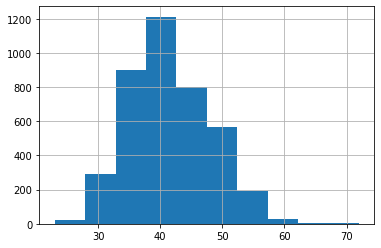

In [ ]:
# Original target distribution
df_fe.depression.hist()

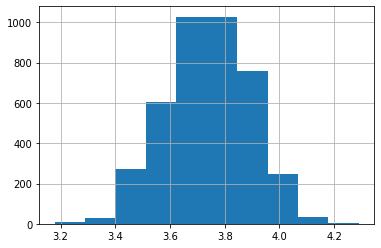

In [ ]:
# Log transformed distribution
np.log1p(df_fe.depression).hist()

In [ ]:
df_fe['depression'] = np.log1p(df_fe['depression'])

# EDA

Data Distribution

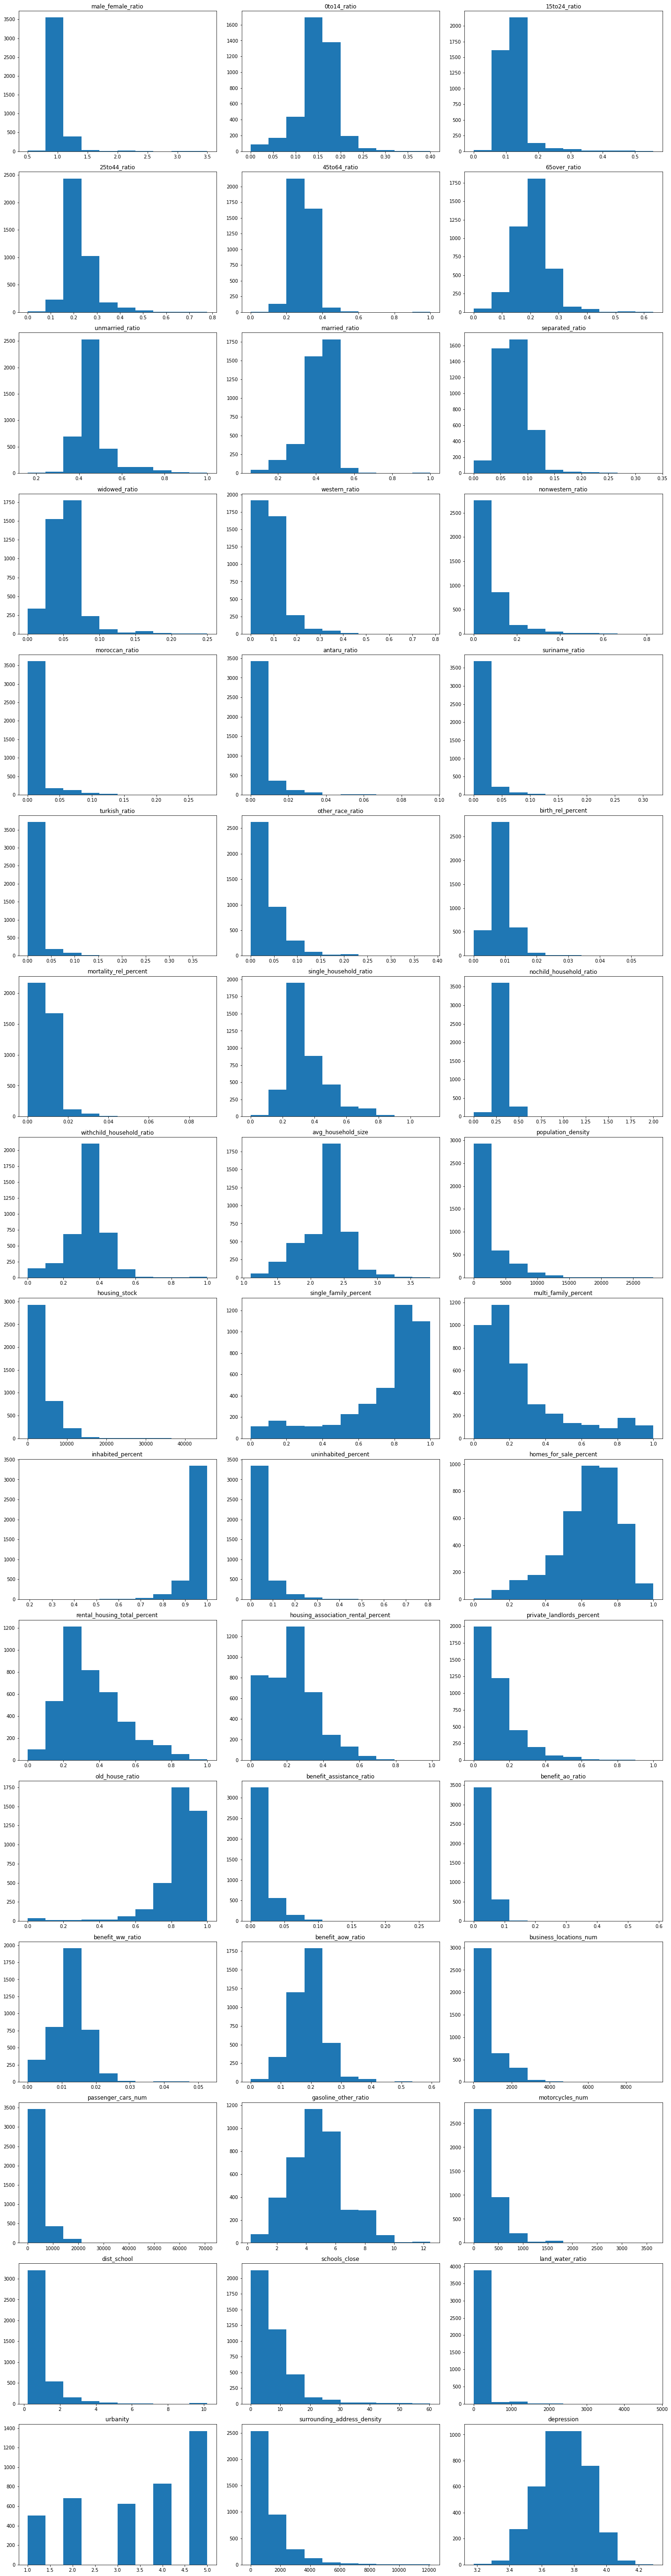

In [ ]:
feature_cols = df_fe.columns
fig, axes = plt.subplots(21, 3, figsize=(20, 100))

for i, ax in enumerate(axes.ravel()):
    if i > 47:
        ax.set_visible(False)
        continue
    ax.hist(df_fe[feature_cols[i]])  
    ax.set_title(feature_cols[i])
plt.tight_layout()

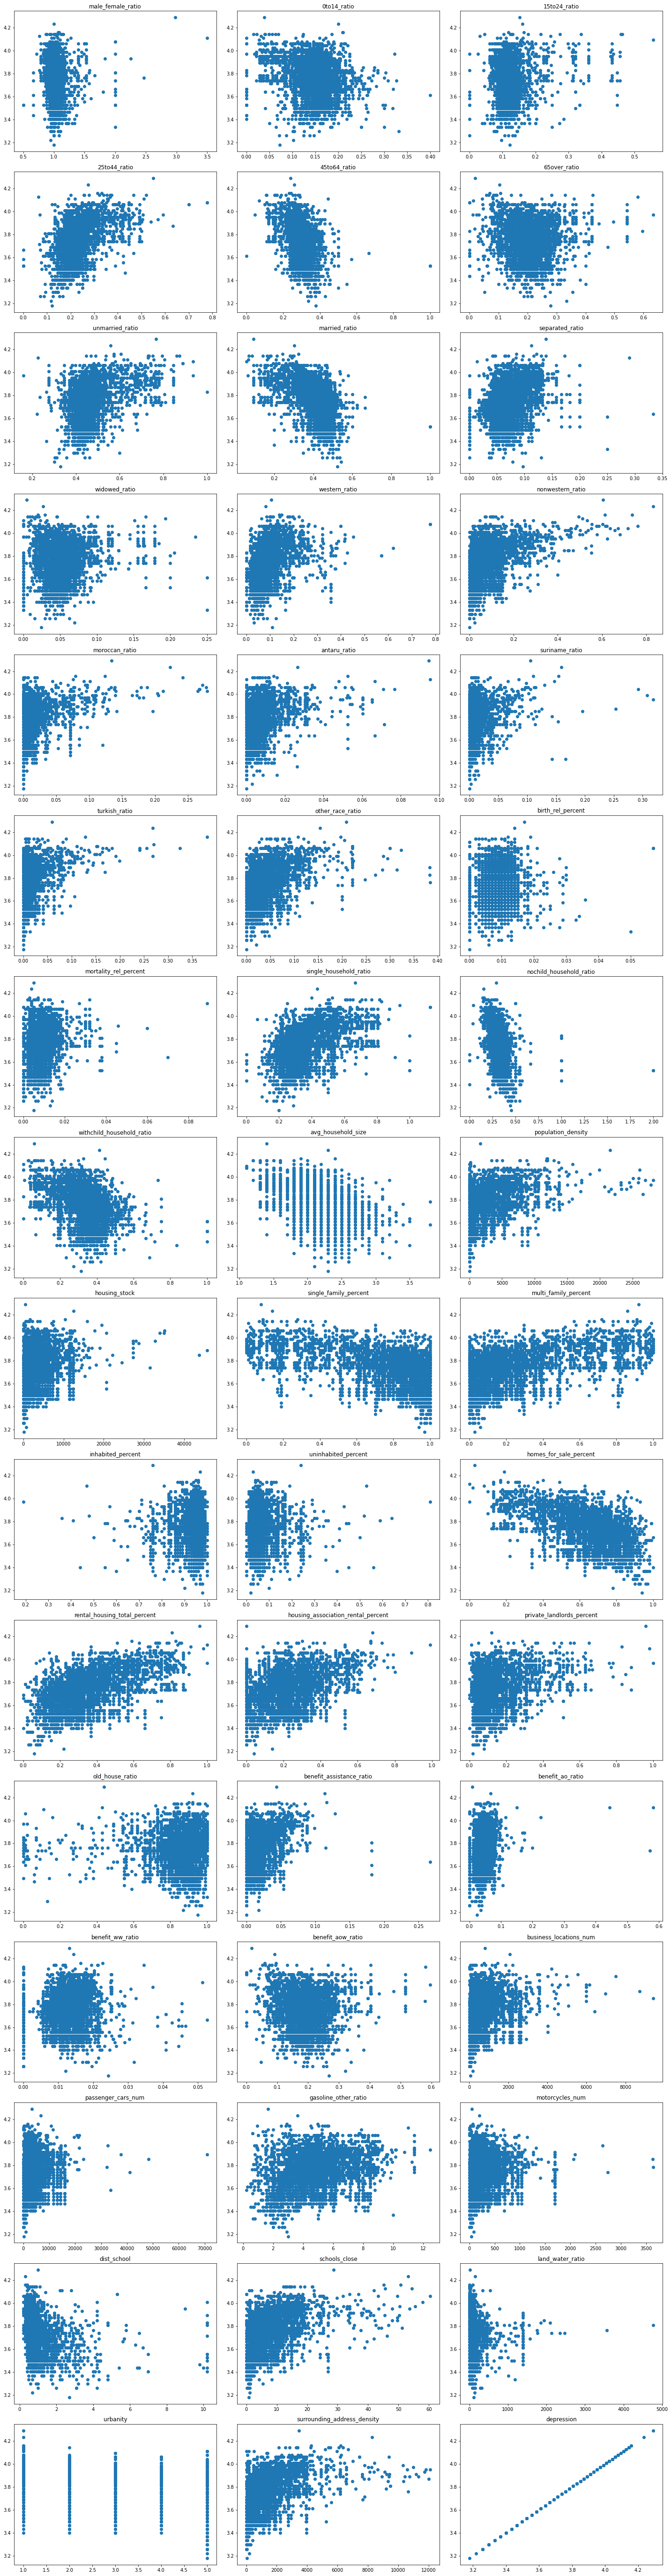

In [ ]:
feature_cols = df_fe.columns
fig, axes = plt.subplots(21, 3, figsize=(20, 100))

for i, ax in enumerate(axes.ravel()):
    if i > 47:
        ax.set_visible(False)
        continue
    ax.scatter(df_fe[feature_cols[i]], df_fe['depression'])  
    ax.set_title(feature_cols[i])
plt.tight_layout()

Correlation Heatmap

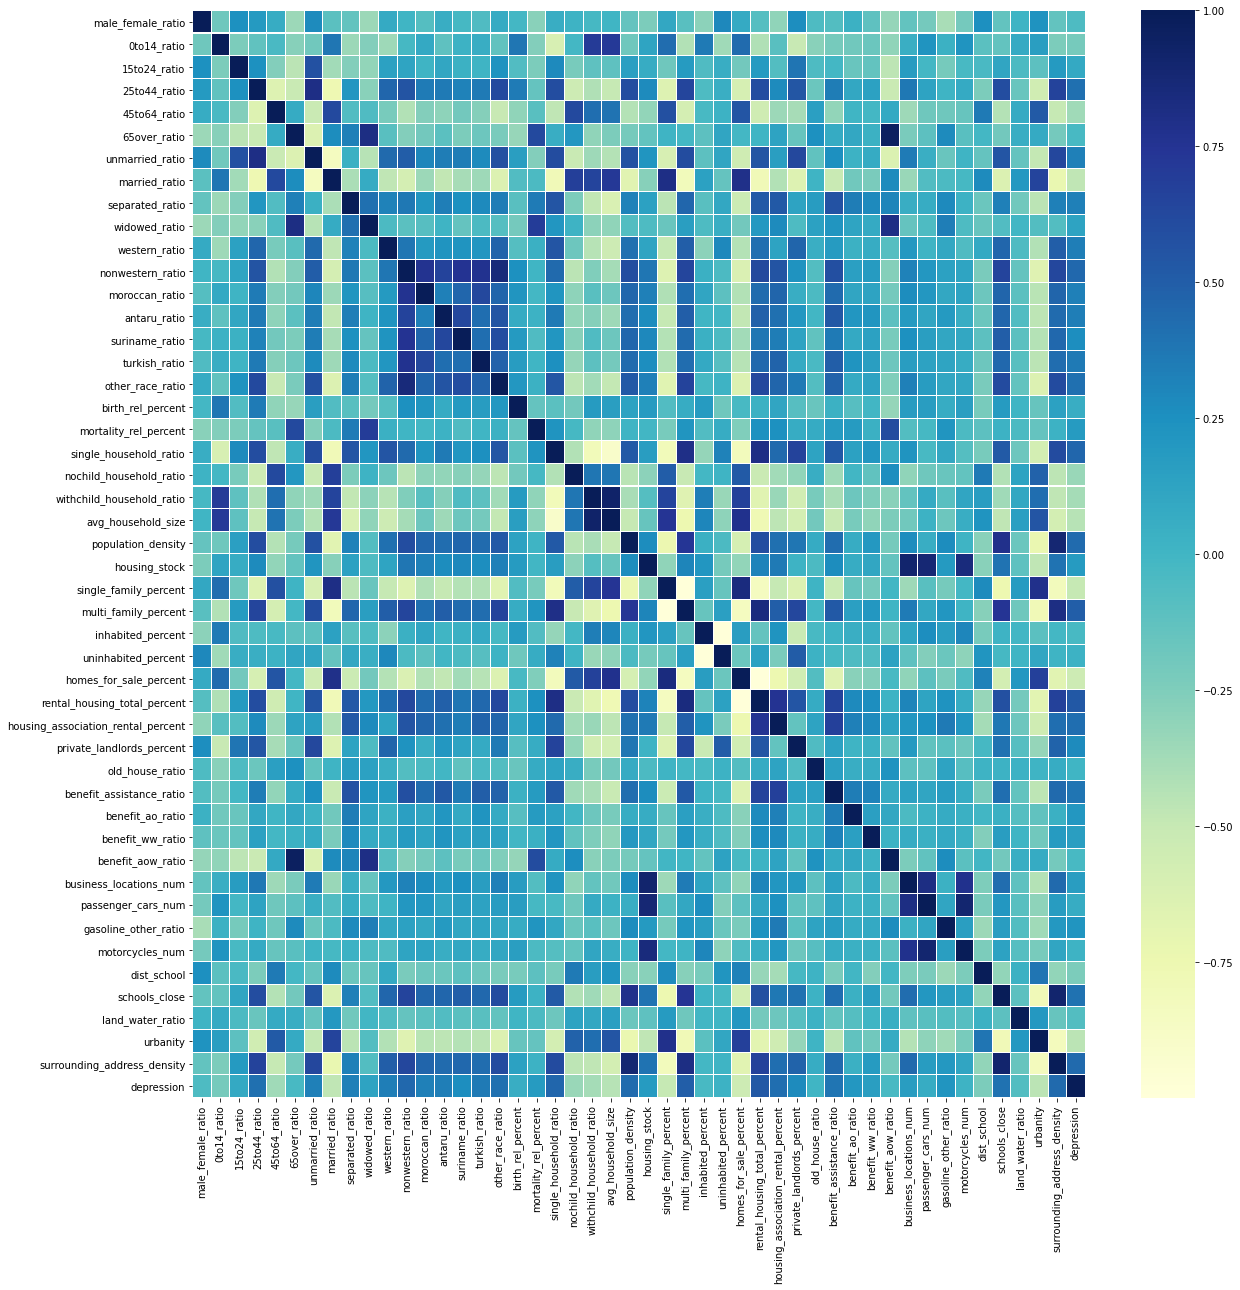

In [ ]:
plt.figure(figsize=(20, 20))
corr = df_fe.corr()
sns.heatmap(corr, 
            annot=False, 
            linewidth=0.1,
            cmap='YlGnBu')
plt.show()

# Building Regression Model

In [ ]:
X = df_fe.drop(['depression'], axis=1)
y = df_fe['depression']

## OLS

In [2]:
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import seaborn as sns

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
lr = LinearRegression().fit(X_train, y_train)
print("training set score: %f" % lr.score(X_train, y_train)) 
print("test set score: %f" % lr.score(X_test, y_test))

In [ ]:
print("R^2: " + str(np.mean(cross_val_score(LinearRegression(), X_train, y_train, cv = 10))))

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

ols = LinearRegression()
ols.fit(X_train, y_train)
predy = ols.predict(X_train)
predy[:5]
print("MSE: " + str(mean_squared_error(y_train, predy)))
print("MAE: " + str(mean_absolute_error(y_train, predy)))

In [ ]:
ols_pipe = Pipeline([('scaler', StandardScaler()),
                   ('regressor',LinearRegression())])

param_grid = {'scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']}

grid = GridSearchCV(ols_pipe, param_grid, cv = 5, return_train_score = True)
grid.fit(X_train,y_train)
print(grid.best_params_)
print(grid.score(X_train,y_train))

In [ ]:
scaler = MinMaxScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

lr = LinearRegression().fit(X_train, y_train)
print("NONSCALED lr.coef_: %s" % lr.coef_) 
print("NONSCALED lr.intercept_: %s" % lr.intercept_, "\n")

lr = LinearRegression().fit(X_train_scaled, y_train)
print("SCALED lr.coef_: %s" % lr.coef_) 
print("SCALED lr.intercept_: %s" % lr.intercept_)

## Ridge

In [ ]:
print("R^2: " + str(np.mean(cross_val_score(Ridge(), X_train, y_train, cv = 10))))

In [ ]:
ridge = Ridge().fit(X_train, y_train)
print("training set score: %f" % ridge.score(X_train, y_train)) 
print("test set score: %f" % ridge.score(X_test, y_test))

In [ ]:
ridge_pipe = Pipeline([('scaler', StandardScaler()),
                   ('Ridge',Ridge())])

param_grid = {'scaler': [StandardScaler(), MinMaxScaler(), 'passthrough'],
              'Ridge__alpha': np.arange(0.01, 10, 0.1)}

grid = GridSearchCV(ridge_pipe, param_grid, cv = 5, return_train_score = True)
grid.fit(X_train,y_train)
print(grid.best_params_)
print(grid.score(X_train,y_train))

In [ ]:
# maybe polynomials will help R^2 score
from sklearn.preprocessing import PolynomialFeatures, scale
X_poly = PolynomialFeatures(include_bias = False).fit_transform(scale(X))
print(X.shape)
print(X_poly.shape)
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, random_state = 42)

In [ ]:
param_grid = {'alpha': np.logspace(-3, 3, 13)}
print(param_grid)
grid = GridSearchCV(Ridge(), param_grid, cv = 5, return_train_score = True)
grid.fit(X_train, y_train)

grid = GridSearchCV(Ridge(), param_grid, return_train_score = True, cv = 10)
grid.fit(X_train, y_train)
results = pd.DataFrame(grid.cv_results_)
results.plot('param_alpha', 'mean_train_score')
results.plot('param_alpha', 'mean_test_score', ax = plt.gca())
plt.fill_between(results.param_alpha.astype(np.float),
                 results['mean_train_score'] + results['std_train_score'],
                 results['mean_train_score'] - results['std_train_score'], alpha = 0.2)
plt.fill_between(results.param_alpha.astype(np.float),
                 results['mean_test_score'] + results['std_test_score'],
                 results['mean_test_score'] - results['std_test_score'], alpha = 0.2)
plt.legend()
plt.xscale("log")

In [ ]:
print(grid.best_estimator_)
print(grid.best_score_)

In [ ]:
ridge = Ridge(alpha=1000).fit(X_train, y_train)
print("training set score: %f" % ridge.score(X_train, y_train)) 
print("test set score: %f" % ridge.score(X_test, y_test))

In [ ]:
predy = ridge.predict(X_train)
predy[:5]
print("MSE: " + str(mean_squared_error(y_train, predy)))
print("MAE: " + str(mean_absolute_error(y_train, predy)))

## Lasso

In [ ]:
# with polynomials
lasso = Lasso().fit(X_train, y_train)
print("training set score: %f" % lasso.score(X_train, y_train)) 
print("test set score: %f" % lasso.score(X_test, y_test)) 
print("how many features used: %d" % np.sum(lasso.coef_ != 0))
print(X_poly.shape)

In [ ]:
# without polynomials
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
lasso = Lasso().fit(X_train, y_train)
print("training set score: %f" % lasso.score(X_train, y_train)) 
print("test set score: %f" % lasso.score(X_test, y_test)) 
print("how many features used: %d" % np.sum(lasso.coef_ != 0))
print(X.shape)

In [ ]:
predy = lasso.predict(X_train)
predy[:5]
print("MSE: " + str(mean_squared_error(y_train, predy)))
print("MAE: " + str(mean_absolute_error(y_train, predy)))

In [ ]:
lasso_pipe = Pipeline([('scaler', StandardScaler()),
                   ('Lasso', Lasso())])

param_grid = {'scaler': [StandardScaler(), MinMaxScaler(), 'passthrough'],
              'Lasso__alpha': np.arange(0.01, 10, 0.1)}

grid = GridSearchCV(lasso_pipe, param_grid, cv = 5, return_train_score = True)
grid.fit(X_train,y_train)
print(grid.best_params_)
print(grid.score(X_train,y_train))

In [ ]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=100)

for alpha, marker in zip([0.01, 1, 100], ['o', '^', 'v']):
    lasso = Lasso(alpha=alpha).fit(X_train, y_train)
    print("Training accuracy of lasso with alpha={:.3f}: {:.2f}".format(
          alpha, lasso.score(X_train, y_train)))
    print("Test accuracy of lasso with alpha={:.3f}: {:.2f}".format(
          alpha, lasso.score(X_test, y_test)))
    plt.plot(lasso.coef_.T, marker, label="alpha={:.3f}".format(alpha))

#plt.xticks(range(X.shape[1]), X.columns, rotation=90)
xlims = plt.xlim()
plt.hlines(0, xlims[0], xlims[1])
plt.xlim(xlims)
plt.xlabel("Feature")
plt.ylabel("Coefficient magnitude")

plt.ylim(-1.5, 1.5)
plt.legend(loc=3)

## Random Forest Regressor

Base Model

In [ ]:
X_train ,X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

rfr_reg = RandomForestRegressor(n_estimators=500, random_state=100)
rfr_reg.fit(X_train, y_train)

pred_rfr = rfr_reg.predict(X_test)

pred_rfr = np.expm1(pred_rfr)
y_test = np.expm1(y_test)
rmse = np.sqrt(mean_squared_error(y_test, pred_rfr))
print(rmse)

4.908594682188642


Delete outliers with Isolation Forest

In [ ]:
iso_clf = IsolationForest(max_samples=1000)
iso_clf.fit(df_fe)

y_pred_outliers = iso_clf.predict(df_fe)

out = pd.DataFrame(y_pred_outliers)
out = out.rename(columns={0: "out"})
df_fe_outliers_corrected = pd.concat([df_fe, out], 1)
df_fe_outliers_corrected = df_fe_outliers_corrected.dropna().drop(['out'], axis=1)

X = df_fe_outliers_corrected.drop(['depression'], axis=1)
y = df_fe_outliers_corrected['depression']

In [ ]:
X_train ,X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

rfr_reg = RandomForestRegressor(n_estimators=500, random_state=100)
rfr_reg.fit(X_train, y_train)
pred_rfr = rfr_reg.predict(X_test)
pred_rfr = np.expm1(pred_rfr)
y_test = np.expm1(y_test)
rmse = np.sqrt(mean_squared_error(y_test, pred_rfr))
print(rmse)

4.969762035510001


Outlier deletion has no improvement (4.90 -> 4.96)


Feature Selection - RFE method  
- Use only 40 best features

In [ ]:
# Disregard outlier deletion

X = df_fe.drop(['depression'], axis=1)
y = df_fe['depression']

X_train ,X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

In [ ]:
rfe = RFE(rfr_reg, n_features_to_select=40, verbose=1)
rfe_fit = rfe.fit(X_train, y_train)

selected_lst = []
for idx in range(len(rfe_fit.support_)):
  if rfe_fit.support_[idx] == True:
    selected_lst.append(df_fe.columns.to_list()[idx])

print(selected_lst)

Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
['male_female_ratio', '0to14_ratio', '15to24_ratio', '25to44_ratio', '45to64_ratio', 'unmarried_ratio', 'married_ratio', 'separated_ratio', 'widowed_ratio', 'western_ratio', 'nonwestern_ratio', 'moroccan_ratio', 'antaru_ratio', 'suriname_ratio', 'turkish_ratio', 'other_race_ratio', 'single_household_ratio', 'nochild_household_ratio', 'withchild_household_ratio', 'population_density', 'single_family_percent', 'multi_family_percent', 'inhabited_percent', 'homes_for_sale_percent', 'rental_housing_total_percent', 'housing_association_rental_percent', 'private_landlords_percent', 'old_house_ratio', 'benefit_assistance_ratio', 'benefit_ao_ratio', 'benefit_ww_ratio', 'benefit_aow_ratio', 'business_locations_num', 'passenger_cars_num', 'gasoline_

In [ ]:
rfr_reg = RandomForestRegressor(n_estimators=500, random_state=100)
rfr_reg.fit(X_train[selected_lst], y_train)

pred_rfr = rfr_reg.predict(X_test[selected_lst])
pred_rfr = np.expm1(pred_rfr)
y_test = np.expm1(y_test)
rmse = np.sqrt(mean_squared_error(y_test, pred_rfr))
print(rmse)

4.91344162974006


Feature selection has no improvement (4.90 -> 4.91)


Hyper parameter tuning

In [ ]:
# There was no improvement in feature selection, so we use the whole features (but outlier deleted)
X = df_fe.drop(['depression'], axis=1)
y = df_fe['depression']

X_train ,X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

rf_param_grid = {'n_estimators': [500],
                 'max_features': ["sqrt", "log2"],
                 'max_depth': [5, 6, 7, 8],
                 'min_samples_split': [0.5, 0.7 , 0.9]}

rf_grid = GridSearchCV(estimator=rfr_reg,
                       param_grid=rf_param_grid,
                       scoring='neg_mean_squared_error',
                       n_jobs=-1)

rf_grid.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=500, n_jobs=None,
                                             oob_score=False, random_state=100,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_

In [ ]:
print(rf_grid.best_params_)

{'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 0.5, 'n_estimators': 500}


In [ ]:
rfr_reg = RandomForestRegressor(n_estimators=rf_grid.best_params_['n_estimators'], 
                                min_samples_split=rf_grid.best_params_['min_samples_split'], 
                                max_features=rf_grid.best_params_['max_features'], 
                                max_depth=rf_grid.best_params_['max_depth'],
                                random_state=100)
rfr_reg.fit(X_train, y_train)
pred_rfr = rfr_reg.predict(X_test)
pred_rfr = np.expm1(pred_rfr)
y_test = np.expm1(y_test)
rmse = np.sqrt(mean_squared_error(y_test, pred_rfr))
print(rmse)

5.529783768716926


## XGBoost Regressor

Base Model

In [ ]:
X = df_fe.drop(['depression'], axis=1)
y = df_fe['depression']

In [ ]:
X_train ,X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

xgb_reg = XGBRegressor(n_estimators=500)
xgb_reg.fit(X_train, y_train)
pred_xgb = xgb_reg.predict(X_test)
pred_xgb = np.expm1(pred_xgb)
y_test = np.expm1(y_test)
rmse = np.sqrt(mean_squared_error(y_test, pred_xgb))
print(rmse)

[08:28:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
4.959594438030662


Delete outliers with Isolation Forest

In [ ]:
iso_clf = IsolationForest(max_samples=1000, random_state=100)
iso_clf.fit(df_fe)

y_pred_outliers = iso_clf.predict(df_fe)

out = pd.DataFrame(y_pred_outliers)
out = out.rename(columns={0: "out"})
df_fe_outliers_corrected = pd.concat([df_fe, out], 1)
df_fe_outliers_corrected = df_fe_outliers_corrected.dropna().drop(['out'], axis=1)

X = df_fe_outliers_corrected.drop(['depression'], axis=1)
y = df_fe_outliers_corrected['depression']

In [ ]:
X_train ,X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

xgb_reg = XGBRegressor(n_estimators=500)
xgb_reg.fit(X_train, y_train)
pred_xgb = xgb_reg.predict(X_test)
pred_xgb = np.expm1(pred_xgb)
y_test = np.expm1(y_test)
rmse = np.sqrt(mean_squared_error(y_test, pred_xgb))
print(rmse)

[08:28:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
4.91871077824626


Outlier deletion has improved the model 4.95 -> 4.91

Feature Selection - RFE method  
- Use only 40 best features

In [ ]:
rfe = RFE(xgb_reg, n_features_to_select=40, verbose=1)
rfe_fit = rfe.fit(X_train, y_train)

selected_lst = []
for idx in range(len(rfe_fit.support_)):
  if rfe_fit.support_[idx] == True:
    selected_lst.append(df_fe.columns.to_list()[idx])

print(selected_lst)

Fitting estimator with 47 features.
[08:29:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fitting estimator with 46 features.
[08:29:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fitting estimator with 45 features.
[08:29:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fitting estimator with 44 features.
[08:29:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fitting estimator with 43 features.
[08:29:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fitting estimator with 42 features.
[08:29:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fitting estimator with

In [ ]:
X_fs = df_fe_outliers_corrected[selected_lst]
y = df_fe_outliers_corrected['depression']

X_train ,X_test, y_train, y_test = train_test_split(X_fs, y, test_size=0.2, random_state=100)

xgb_reg = XGBRegressor(n_estimators=500)
xgb_reg.fit(X_train, y_train)

pred_xgb = xgb_reg.predict(X_test)
pred_xgb = np.expm1(pred_xgb)
y_test = np.expm1(y_test)
rmse = np.sqrt(mean_squared_error(y_test, pred_xgb))
print(rmse)

[08:30:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
4.916602304507644


Using only 40 features from RFE slightly improved the model 4.918 to 4.916

Hyper parameter tuning - gridsearchcv

In [ ]:
X_train ,X_test, y_train, y_test = train_test_split(X_fs, y, test_size=0.2, random_state=100)

xgb_param_grid = {'n_estimators': [500],
                  'learning_rate': [0.05],
                  'colsample_bytree': [0.5, 1],
                  'subsample': [0.6, 0.8, 1.0]}

xgb_grid = GridSearchCV(estimator=xgb_reg,
                        param_grid=xgb_param_grid,
                        scoring='neg_mean_squared_error',
                        n_jobs=-1)

xgb_grid.fit(X_train, y_train)

[08:31:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=None, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=500, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 1], 'learning_rate': [0.05],
                         'n_estimators': [500], 'su

In [ ]:
print(xgb_grid.best_params_)

{'colsample_bytree': 1, 'learning_rate': 0.05, 'n_estimators': 500, 'subsample': 0.6}


In [ ]:
xgb_reg = XGBRegressor(n_estimators=xgb_grid.best_params_['n_estimators'], 
                       learning_rate=xgb_grid.best_params_['learning_rate'], 
                       colsample_bytree=xgb_grid.best_params_['colsample_bytree'], 
                       subsample=xgb_grid.best_params_['subsample'])
xgb_reg.fit(X_train, y_train)
pred_xgb = xgb_reg.predict(X_test)
pred_xgb = np.expm1(pred_xgb)
y_test = np.expm1(y_test)
rmse = np.sqrt(mean_squared_error(y_test, pred_xgb))
print(rmse)

[08:31:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
4.886328267545324


## Neural Network

In [ ]:
X_train ,X_test, y_train, y_test = train_test_split(X_fs, y, test_size=0.2, random_state=100)

In [ ]:
model = Sequential()
model.add(Dense(64, input_dim=40, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 64)                2624      
_________________________________________________________________
dense_28 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_29 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_30 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 9         
Total params: 5,377
Trainable params: 5,377
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='mean_squared_error', 
              optimizer=Adam(learning_rate=0.002))

MC = ModelCheckpoint(filepath='model.hdf5', monitor='val_loss', verbose=1, save_best_only=True)
EC = EarlyStopping(monitor='val_loss', patience=100)

hist = model.fit(X_train, y_train, 
                 validation_split=0.2, 
                 epochs=5000,
                 callbacks=[EC, MC])

Epoch 1/5000
64/64 [==============================] - 1s 4ms/step - loss: 3484.4699 - val_loss: 140.8082

Epoch 00001: val_loss improved from inf to 140.80817, saving model to model.hdf5
Epoch 2/5000
64/64 [==============================] - 0s 2ms/step - loss: 231.1924 - val_loss: 99.6424

Epoch 00002: val_loss improved from 140.80817 to 99.64240, saving model to model.hdf5
Epoch 3/5000
64/64 [==============================] - 0s 2ms/step - loss: 2128.4595 - val_loss: 248.6179

Epoch 00003: val_loss did not improve from 99.64240
Epoch 4/5000
64/64 [==============================] - 0s 2ms/step - loss: 164.4813 - val_loss: 25.2833

Epoch 00004: val_loss improved from 99.64240 to 25.28329, saving model to model.hdf5
Epoch 5/5000
64/64 [==============================] - 0s 2ms/step - loss: 14.7645 - val_loss: 20.2413

Epoch 00005: val_loss improved from 25.28329 to 20.24132, saving model to model.hdf5
Epoch 6/5000
64/64 [==============================] - 0s 2ms/step - loss: 12.4795 - val_

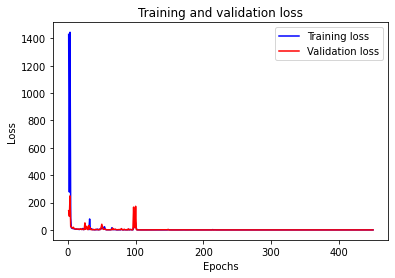

In [ ]:
hist_dct = hist.history
loss = hist_dct['loss']
val_loss = hist_dct['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

No overfitting was observed

In [ ]:
model = tf.keras.models.load_model('model.hdf5')

In [ ]:
pred_nn = model.predict(X_test).flatten()
pred_nn = np.expm1(pred_nn)
y_test = np.expm1(y_test)
rmse = np.sqrt(mean_squared_error(y_test, pred_nn))
print(rmse)

6.119687241621541


More data was required for neural network training, therefore it did not provide better performance than tree-based models due to less data.